In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv("Wage.csv")

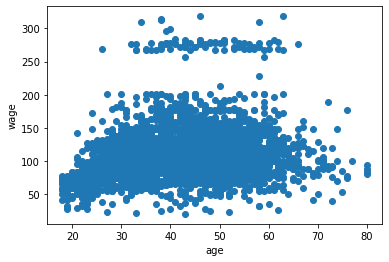

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

X = pd.DataFrame(data['age'].astype(int))
y = data['wage']

plt.xlabel("age")
plt.ylabel("wage")

plt.scatter(X, y)

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

k = 10

kf = KFold(n_splits=k)

scores = []
best_degree = 0
best_score = np.inf

lm = LinearRegression()

for a in np.arange(1,11):
  poly = PolynomialFeatures(a)
  polyX = pd.DataFrame(poly.fit_transform(X))

  CVsum = 0
  for train_indices, test_indices in kf.split(polyX, y):
    predictions = lm.fit(polyX.iloc[train_indices], y[train_indices]).predict(polyX.iloc[test_indices])
    #we need RSS
    RSS = len(test_indices) * mean_squared_error(y[test_indices], predictions)
    CVsum = CVsum + RSS

  CV = CVsum / k
  scores.append(CV)

  if CV < best_score:
    best_score = CV
    best_degree = a

Best degree is: 
4


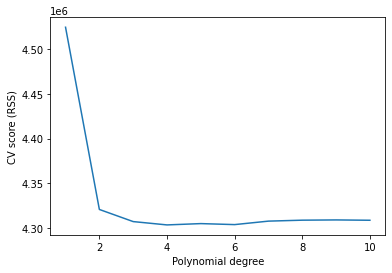

In [ ]:
plt.xlabel("Polynomial degree")
plt.ylabel("CV score (RSS)")

plt.plot(range(1,11), scores)

print("Best degree is: ")
print(best_degree)

In [ ]:
poly = PolynomialFeatures(best_degree)
polyX = pd.DataFrame(poly.fit_transform(X))
bestPolyFit = lm.fit(polyX, y)


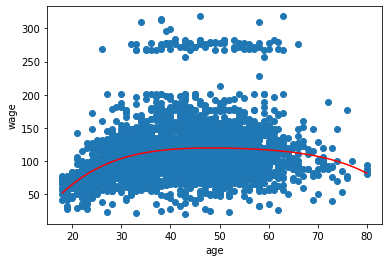

In [ ]:
xRange = pd.DataFrame(np.arange(min(X['age']), max(X['age']), (max(X['age']) - min(X['age'])) / len(X['age'])))
polyXRange = poly.fit_transform(xRange)
yPolyPredict = bestPolyFit.predict(polyXRange)

plt.xlabel("age")
plt.ylabel("wage")
plt.scatter(X,y)
plt.plot(xRange.iloc[:, 0], yPolyPredict, 'r')

In [ ]:
import statsmodels.api as sm

step_scores = []
best_cuts = 0
step_best_score = np.inf

maxNumCuts = 40

for a in np.arange(1,maxNumCuts):
  CVsum = 0
  for train_indices, test_indices in kf.split(X, y):
    X_train, X_test, y_train, y_test = X.iloc[train_indices], X.iloc[test_indices], y[train_indices], y[test_indices]
    
    df_cut, bins = pd.cut(X_train['age'], a, retbins=True, right=True)
    df_cut.value_counts(sort=False)
    df_steps = pd.concat([X_train['age'], df_cut, y_train], keys=['age','age_cuts','wage'], axis=1)

    # Create dummy variables for the age groups
    df_steps_dummies = pd.get_dummies(df_cut)

    # Fitting Generalised linear models
    fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()

    # Binning validation set into same 4 bins
    X_valid = pd.DataFrame(np.digitize(X_test['age'], bins), columns=['bins'])

    #manually create dummy variables
    for b in range(0, a):
      X_valid[b] = np.where(X_valid['bins'] == b, 1, 0)

    #we don't need this anymore
    X_valid=X_valid.drop(['bins'], axis=1)


    # Prediction
    predictions = fit3.predict(X_valid)
    
    #we need RSS
    RSS = len(test_indices) * mean_squared_error(y[test_indices], predictions)
    CVsum = CVsum + RSS

  CV = CVsum / k
  step_scores.append(CV)

  if CV < step_best_score:
    step_best_score = CV
    best_cuts = a


Best number of cuts is: 
28


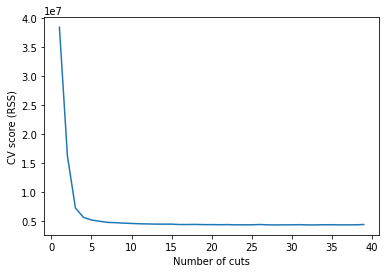

In [ ]:
plt.xlabel("Number of cuts")
plt.ylabel("CV score (RSS)")

plt.plot(range(1,maxNumCuts), step_scores)

print("Best number of cuts is: ")
print(best_cuts)

In [ ]:
df_cut, bins = pd.cut(X['age'], best_cuts, retbins=True, right=True)
df_cut.value_counts(sort=False)
df_steps = pd.concat([X['age'], df_cut, y], keys=['age','age_cuts','wage'], axis=1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_cut)

# Fitting Generalised linear models
bestStepFit = sm.GLM(df_steps.wage, df_steps_dummies).fit()

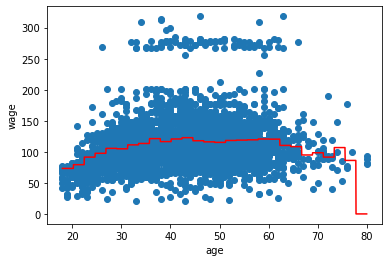

In [ ]:
# Binning validation set into same 4 bins
xStepRange = pd.DataFrame(np.digitize(xRange, bins), columns=['bins'])

#manually create dummy variables
for b in range(0, best_cuts):
  xStepRange[b] = np.where(xStepRange['bins'] == b, 1, 0)

#we don't need this anymore
xStepRange=xStepRange.drop(['bins'], axis=1)

yStepPredict = bestStepFit.predict(xStepRange)

plt.xlabel("age")
plt.ylabel("wage")
plt.scatter(X,y)
plt.plot(xRange.iloc[:, 0], yStepPredict, 'r')